In [1]:
import sys,os,glob
os.environ['PROJ_LIB'] = '/home/piotr/anaconda3/lib/python3.8/site-packages/rasterio/proj_data/'
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import geopandas
import pandas as pd
from geocube.api.core import make_geocube
from datetime import datetime
from matplotlib.dates import DateFormatter
from PIL import Image
from osgeo import gdal

# Processing MODIS and CHIRPS data
extracts time series of inundation from merged inundation maps file

In [10]:
unitsfilepath="../data/gis/delta_units_v7.shp"
rainfallfilepath="../data/rainfall/pr_mon_CHG_CHIRPS-2.0-0p25-prelim_merged_okavango.nc"
floodfilepath="../data/flood/flood_modis_merged.nc"

#these are output files
rainfall4unitsfilepath="../data/rainfall/pr_deltaunits.csv"
flood4unitsfilepath="../data/flood/flood_deltaunits.csv"

verbose=False

###############################################################################################################
if not os.path.exists(unitsfilepath):
    print("Units file {} does not exist. Exiting...".format(unitsfilepath))
    sys.exit()


units = geopandas.read_file(unitsfilepath)

#processing rainfall
print("reading rainfall file {}".format(rainfallfilepath))
data=xr.open_dataset(rainfallfilepath,chunks={'time': 20})
pr=data.pr
data.close()
pr=pr.rio.write_crs("epsg:4326")

if verbose:
    fig=plt.figure(figsize=(6,8))
    pl=fig.add_subplot(1,1,1)
    m=(pr.mean("time")*12).sel(latitude=slice(-21,-18), longitude=slice(21,24.5)).plot(add_colorbar=False, cmap=plt.cm.BrBG)
    units.plot(ax=pl, alpha=0.3, edgecolor='black', color="white", linewidth=1)
    plt.colorbar(m, shrink=0.5)
    pl.set_title("mean annual rainfall [mm/year]")
    plt.show()

print("processing rainfall...")
subprpd=pd.DataFrame()
for unit in range(8):
    if verbose:
        print(unit)
    subpr=pr.rio.clip(units.geometry.values[unit:(unit+1)], "epsg:4326")
    subpr=subpr.mean(("latitude","longitude")).to_pandas()
    subpr.name=units["NAME"][unit]
    subprpd=pd.concat([subprpd,subpr], axis=1)
subprpd.index=pd.to_datetime([datetime.date(x) for x in subprpd.index])
print("done")
print("writing rainfall file {}".format(rainfall4unitsfilepath))
np.round(subprpd,2).to_csv(rainfall4unitsfilepath)
print("done")

processing rainfall...
done
writing rainfall file ../data/rainfall/pr_deltaunits.csv
done


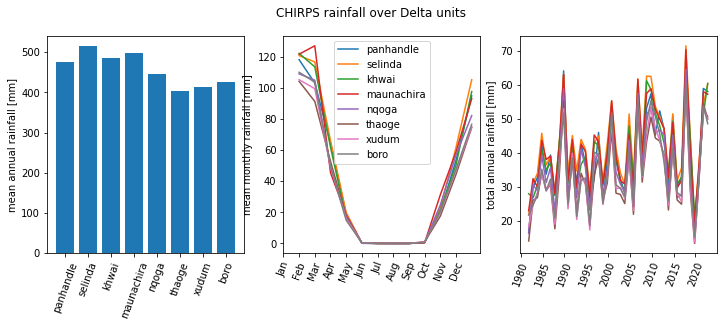

In [50]:
if not os.path.exists(rainfallfilepath):
    print("Rainfall file {} does not exist. Exiting...".format(rainfallfilepath))
    sys.exit()

    
pr=subprpd
fig=plt.figure(figsize=(12,4))

pl=fig.add_subplot(1,3,1)
    
pl.bar(range(pr.shape[1]),pr.mean(0)*12, tick_label=pr.keys())
plt.xticks(rotation=70)
pl.set_ylabel("mean annual rainfall [mm]")

monthnames=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
pl=fig.add_subplot(1,3,2)
pr.groupby(pr.index.month).mean().plot(ax=pl)
pl.set_xticks(range(12))
pl.set_xticklabels(monthnames)
plt.legend()
pl.set_ylabel("mean monthly rainfall [mm]")
plt.xticks(rotation=70)

pl=fig.add_subplot(1,3,3)
pl.plot(pr.resample("A-Oct").mean()) #.plot(ax=pl)

pl.set_ylabel("total annual rainfall [mm]")
plt.xticks(rotation=70)

plt.suptitle("CHIRPS rainfall over Delta units")
plt.subplots_adjust(hspace=0.7)
plt.show()


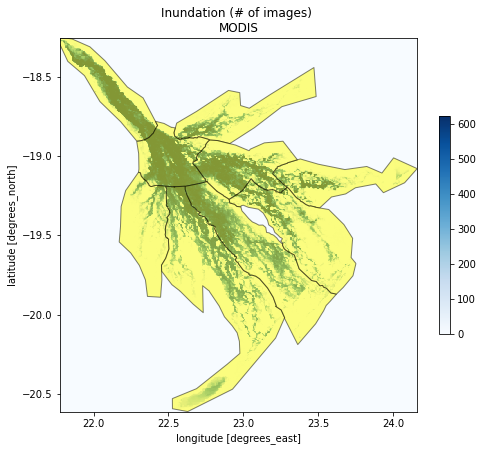

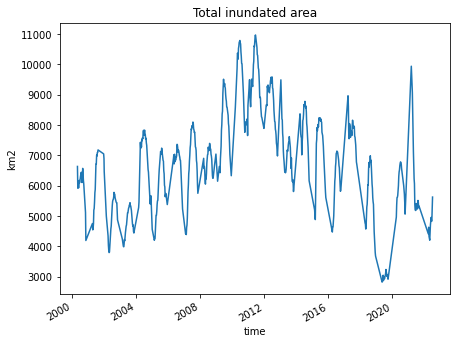

0
1
2
3
4
5
6
7


In [45]:
data=xr.open_dataset("../data/flood/flood_modis_merged.nc",chunks={'time': 10})
flood=data.flood
flood=flood.rio.write_crs("epsg:4326")
data.close()

#inundation map
flood=flood.rio.clip(units.geometry, "epsg:4326")

nans=(flood==2).sum(("latitude","longitude"))
sel=nans<500
flood=flood[sel.values,:,:]


fig=plt.figure(figsize=(8,8))
pl=fig.add_subplot(1,1,1)
m=flood.sum("time").plot(cmap=plt.cm.Blues, ax=pl,add_colorbar=False)
units.plot(ax=pl, alpha=0.5, edgecolor='black', color="yellow",linewidth=1)
plt.colorbar(m, shrink=0.5)
pl.set_title("Inundation (# of images) \nMODIS")
plt.show()



nans=(flood==2).sum(("latitude","longitude"))
#selecting time steps with low coverage of unclassified pixels
sel=nans<500
flood=flood[sel.values,:,:]


fig=plt.figure(figsize=(7,5))
pl=fig.add_subplot(1,1,1)

#divided by 4 because sum gives the number of modis pixels, and they are quarter km2 in size
floodarea=flood.sum(("latitude","longitude"))/4
floodarea.plot()
pl.set_title("Total inundated area")
pl.set_ylabel("km2")
plt.show()


subfloodpd=pd.DataFrame()
for unit in range(8):
    print(unit)
    subflood=flood.rio.clip(units.geometry.values[unit:(unit+1)], "epsg:4326")
    subflood=(subflood.sum(("latitude","longitude"))/4).to_pandas()
    subflood.name=units["NAME"][unit]
    subfloodpd=pd.concat([subfloodpd,subflood], axis=1)
    
subfloodpd.to_csv("../data/flood/flood_modis_okavangounits.csv")

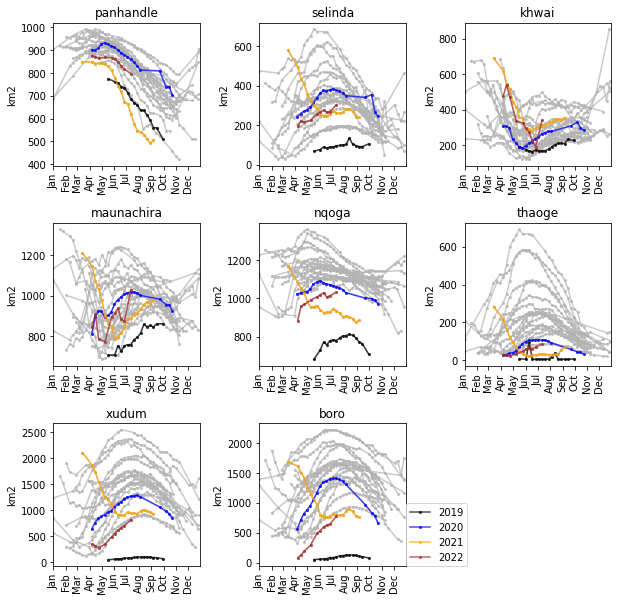

In [44]:
selcolors=["black","blue","orange","brown"]
unit
fig=plt.figure(figsize=(10,10))
for unit in range(8):
    pl=fig.add_subplot(3,3,unit+1)
    
    subflood=flood.astype(float).rio.clip(units.geometry.values[unit:(unit+1)], "epsg:4326")
    subfloodarea=subflood.sum(("latitude","longitude"))/4
    
    subfloodgroup=subfloodarea.groupby(subfloodarea.time.dt.year)
    for d in subfloodgroup.groups.keys():
        color="0.7"
        group=subfloodgroup[d]
        dates=[datetime.utcfromtimestamp(((x-np.datetime64('1970-01-01T00:00:00'))/ np.timedelta64(1, 's'))).replace(year=2022) for x in group.time.data]
        pl.plot(dates,group, "o-", color=color, markersize=2, alpha=0.7, label="_none")
        
    for i,d in enumerate([2019,2020,2021,2022]):
        color=selcolors[i]
        group=subfloodgroup[d]
        dates=[datetime.utcfromtimestamp(((x-np.datetime64('1970-01-01T00:00:00'))/ np.timedelta64(1, 's'))).replace(year=2022) for x in group.time.data]
        pl.plot(dates,group, "o-", color=color, markersize=2, alpha=0.7, label=str(d))
        
    pl.set_xlim(pd.to_datetime("2022-01-01"),pd.to_datetime("2022-12-31"))
    date_form = DateFormatter("%b")
    pl.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation = 90)
    pl.set_ylabel("km2")
    pl.set_title(units["NAME"][unit])
plt.legend(loc=(1,0))
plt.subplots_adjust(wspace=0.4,hspace=0.4)


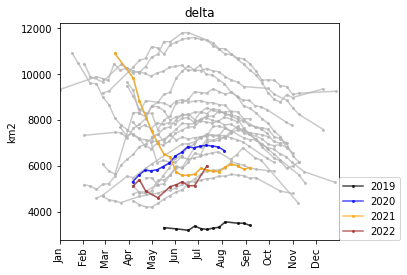

In [67]:
selcolors=["black","blue","orange","brown"]
fig=plt.figure(figsize=(5,4))
pl=fig.add_subplot(1,1,1)

floodarea=flood.sum(("latitude","longitude"))/4

floodgroup=floodarea.groupby(floodarea.time.dt.year)
for d in floodgroup.groups.keys():
    color="0.7"
    group=floodgroup[d]
    dates=[datetime.utcfromtimestamp(((x-np.datetime64('1970-01-01T00:00:00'))/ np.timedelta64(1, 's'))).replace(year=2022) for x in group.time.data]
    pl.plot(dates,group, "o-", color=color, markersize=2, alpha=0.7, label="_none")

for i,d in enumerate([2019,2020,2021,2022]):
    color=selcolors[i]
    group=floodgroup[d]
    dates=[datetime.utcfromtimestamp(((x-np.datetime64('1970-01-01T00:00:00'))/ np.timedelta64(1, 's'))).replace(year=2022) for x in group.time.data]
    pl.plot(dates,group, "o-", color=color, markersize=2, alpha=0.7, label=str(d))

pl.set_xlim(pd.to_datetime("2022-01-01"),pd.to_datetime("2022-12-31"))
date_form = DateFormatter("%b")
pl.xaxis.set_major_formatter(date_form)
plt.xticks(rotation = 90)
pl.set_ylabel("km2")
pl.set_title("delta")
plt.legend(loc=(1,0))
plt.subplots_adjust(wspace=0.4,hspace=0.4)


In [58]:
data=xr.open_dataset("data/tmax_1981-2020_okav.nc")
tmax=data.tmax
data.close()

data=xr.open_dataset("data/tmin_1981-2020_okav.nc")
tmin=data.tmin
data.close()

In [59]:
tmean=(tmax+tmin)/2

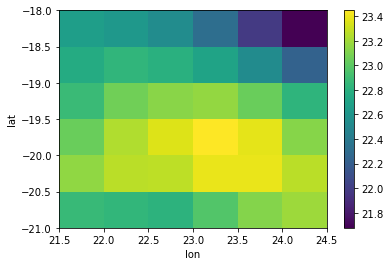

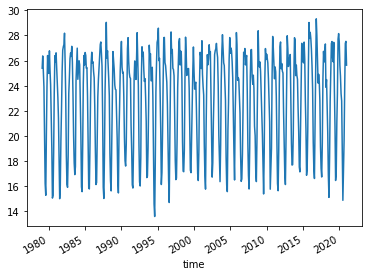

In [61]:
tmean.mean("time").plot()
plt.show()
tmean.mean(("lat","lon")).resample(time="M").mean().plot()

In [64]:
tmeanpd=tmean.mean(("lat","lon")).resample(time="M").mean().to_pandas()

In [63]:
tmeanpd.to_csv()

<xarray.DataArray (time: 15341, lat: 6, lon: 6)>
array([[[27.904842, 27.860052, 27.780266, 27.629581, 27.33144 ,
         26.87326 ],
        [28.12976 , 28.128407, 28.03626 , 27.949215, 27.761108,
         27.359959],
        [28.34654 , 28.398071, 28.311867, 28.24477 , 28.135588,
         27.906582],
        [28.666847, 28.64341 , 28.503677, 28.44693 , 28.34768 ,
         28.15105 ],
        [29.01838 , 28.884666, 28.6685  , 28.558819, 28.515953,
         28.40746 ],
        [29.084457, 28.822437, 28.57543 , 28.549686, 28.587776,
         28.625477]],

       [[26.933754, 26.391258, 26.074993, 26.084354, 26.171288,
         26.143288],
        [26.800455, 26.344145, 26.082108, 26.085419, 26.224867,
         26.267096],
        [26.436817, 26.319748, 26.265976, 26.26682 , 26.302013,
         26.39808 ],
        [25.998528, 26.184158, 26.351734, 26.424677, 26.372902,
...
         24.314651],
        [26.575846, 25.828938, 25.225262, 24.812948, 24.607092,
         24.46455 ],
        [27.565987, 26.557934, 25.562855, 25.056099, 24.866913,
         24.831566],
        [28.116554, 27.19466 , 25.998184, 25.275684, 25.244627,
         25.43966 ]],

       [[24.87579 , 24.797401, 24.665081, 24.591175, 24.458559,
         24.26855 ],
        [25.29943 , 25.132576, 24.88615 , 24.763763, 24.711178,
         24.599289],
        [25.916218, 25.470789, 25.140259, 25.03061 , 24.946888,
         24.903957],
        [26.70117 , 25.868393, 25.365921, 25.229908, 25.145569,
         24.980402],
        [27.330795, 26.29141 , 25.475681, 25.324547, 25.277912,
         25.173557],
        [27.442205, 26.36252 , 25.411087, 25.241783, 25.288961,
         25.28548 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
  * lat      (lat) float32 -18.25 -18.75 -19.25 -19.75 -20.25 -20.75
  * lon      (lon) float32 21.75 22.25 22.75 23.25 23.75 24.25